In [41]:
# mounts Google Drive to the Colab VM
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

# project github foldername
FOLDERNAME = '/content/drive/My Drive/CS231N/Project/RainfallNowcasting/MovingMNIST/'

# load python files from foldername
import sys
sys.path.append(FOLDERNAME)

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

Mounted at /content/drive
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
# Download Moving-MNIST dataset
!wget 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'

--2020-05-17 19:37:42--  http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 819200096 (781M)
Saving to: ‘mnist_test_seq.npy.1’

mnist_test_seq.npy. 100%[===================>] 781.25M  13.0MB/s    in 61s     

2020-05-17 19:38:44 (12.8 MB/s) - ‘mnist_test_seq.npy.1’ saved [819200096/819200096]



In [0]:
# Useful libraries
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 3

In [0]:
#
# Parameters
#
Nsample = 500
Ninput = 10
Noutput = 5
loss = 'binary_crossentropy'

In [45]:
#
# Data processing
#
data = np.load('mnist_test_seq.npy')
data = data.swapaxes(0, 1) # swap frames and instances for tf handling
data = data[:Nsample, :, :, :] # reduce memory and compute requirements by selecting a subsample
data = np.expand_dims(data, -1) # add channel dimension for tf handling (channel=1, ie grayscale)
data = data/np.amax(data) # minmax normalize data
data = tf.cast(data, tf.float32) # convert to float32 for tf handling
N, F, H, W, C = data.shape # save dims
print('(instance, frame, height, width, channel) = '+str(data.shape))
print('min value = '+str(np.amin(data)))
print('max value = '+str(np.amax(data)))

(instance, frame, height, width, channel) = (500, 20, 64, 64, 1)
min value = 0.0
max value = 1.0


In [46]:
#
# Create Input/output dataset: 
# previous frame (X_t-1) is used as input to predict next frame (y_t)
#
def make_train_data(data, cutoff):
  X = data[:, :cutoff, :, :, :]
  y = data[:, cutoff, :, :, :]
  return X, y
X, y = make_train_data(data, Ninput)
print("X is:", X.shape)
print("y is:", y.shape)

X is: (500, 10, 64, 64, 1)
y is: (500, 64, 64, 1)


In [0]:
# Our Model Architecture
def model_init():
    inputs = tf.keras.Input(shape=[None, H, W, C])
    CL1 = tf.keras.layers.ConvLSTM2D(64, 3, padding='same',
                                     activation='elu', kernel_initializer='he_normal',
                                     return_sequences=True)(inputs)
    CL2 = tf.keras.layers.ConvLSTM2D(64, 3, padding='same',
                                     activation='elu', kernel_initializer='he_normal',
                                     return_sequences=True)(CL1)
    CL3 = tf.keras.layers.ConvLSTM2D(64, 3, padding='same',
                                     activation='elu', kernel_initializer='he_normal',
                                     return_sequences=True)(CL2)
    CL4 = tf.keras.layers.ConvLSTM2D(64, 3, padding='same',
                                     activation='elu', kernel_initializer='he_normal',
                                     return_sequences=True)(CL3)
    CL5 = tf.keras.layers.ConvLSTM2D(64, 3, padding='same',
                                     activation='elu', kernel_initializer='he_normal',
                                     return_sequences=True)(CL4)
    CL6 = tf.keras.layers.ConvLSTM2D(64, 3, padding='same',
                                     activation='elu', kernel_initializer='he_normal',
                                     return_sequences=True)(CL5)
    CL7 = tf.keras.layers.ConvLSTM2D(64, 3, padding='same',
                                     activation='elu', kernel_initializer='he_normal',
                                     return_sequences=True)(CL6)
    CL8 = tf.keras.layers.ConvLSTM2D(64, 3,padding='same',
                                     activation='elu', kernel_initializer='he_normal')(CL7)
    preds = tf.keras.layers.Conv2D(1, 1, padding='same', 
                                   activation='sigmoid')(CL8)
    return tf.keras.Model(inputs=inputs, outputs=preds)

In [0]:
# Custom metrics
def ssim(y_gt, y_pred, max_val=1.):
  return tf.image.ssim(y_gt, y_pred, max_val)

def psnr(y_gt, y_pred, max_val=1.):
  return tf.image.psnr(y_gt, y_pred, max_val)

def cor(y_gt, y_pred):
  return tfp.stats.correlation(y_gt, y_pred, sample_axis=None, event_axis=None)

In [49]:
# Initialize model
model = model_init()
# Build optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=loss,
              metrics=['acc', 'mse', 'binary_crossentropy', ssim, psnr, cor,
                       tf.keras.metrics.Precision(name='prec'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.FalseNegatives(name='FN'), 
                       tf.keras.metrics.FalsePositives(name='FP'),
                       tf.keras.metrics.TrueNegatives(name='TN'), 
                       tf.keras.metrics.TruePositives(name='TP')])
# Fit the model
history = model.fit(X, y, batch_size=8, epochs=20, validation_split=0.1)

Epoch 1/20
57/57 [==============================] - 85s 1s/step - loss: 0.2391 - acc: 0.9147 - mse: 0.0522 - binary_crossentropy: 0.2391 - ssim: 0.0552 - psnr: 13.4271 - cor: 0.0750 - prec: 0.1255 - recall: 0.0276 - FN: 128416.0000 - FP: 25382.0000 - TN: 1685759.0000 - TP: 3643.0000 - val_loss: 0.1780 - val_acc: 0.9321 - val_mse: 0.0374 - val_binary_crossentropy: 0.1780 - val_ssim: 0.0564 - val_psnr: 14.3717 - val_cor: 0.1561 - val_prec: 0.0000e+00 - val_recall: 0.0000e+00 - val_FN: 13905.0000 - val_FP: 0.0000e+00 - val_TN: 190895.0000 - val_TP: 0.0000e+00
Epoch 2/20
57/57 [==============================] - 85s 1s/step - loss: 0.1771 - acc: 0.9284 - mse: 0.0384 - binary_crossentropy: 0.1771 - ssim: 0.0884 - psnr: 14.2855 - cor: 0.2323 - prec: 0.0000e+00 - recall: 0.0000e+00 - FN: 132059.0000 - FP: 0.0000e+00 - TN: 1711141.0000 - TP: 0.0000e+00 - val_loss: 0.1555 - val_acc: 0.9320 - val_mse: 0.0348 - val_binary_crossentropy: 0.1555 - val_ssim: 0.1203 - val_psnr: 14.6861 - val_cor: 0.287

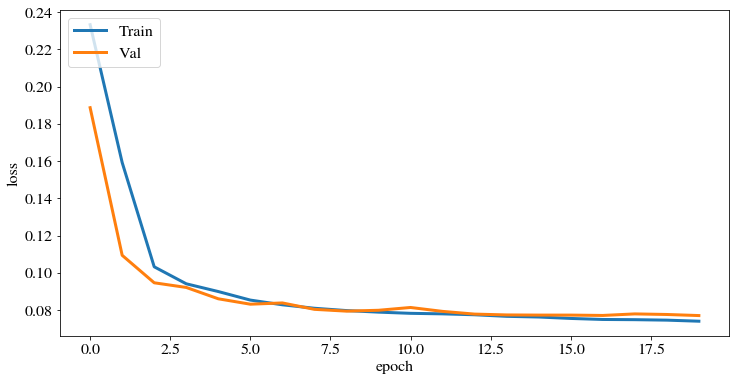

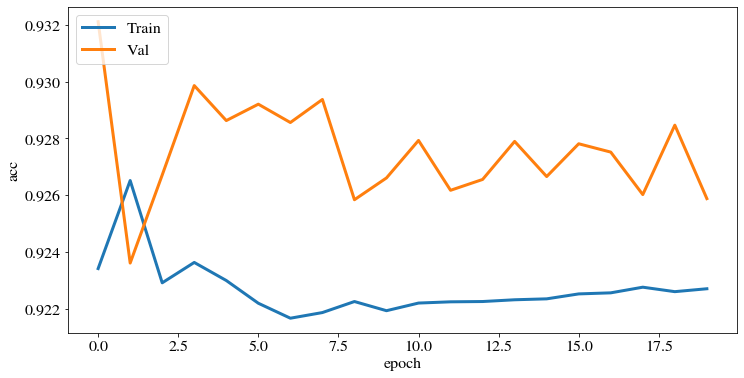

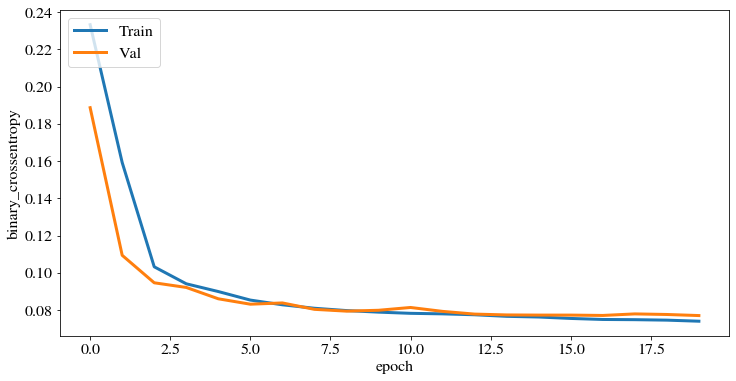

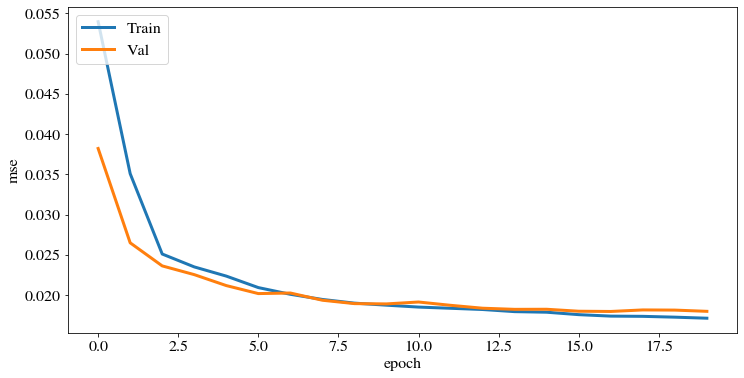

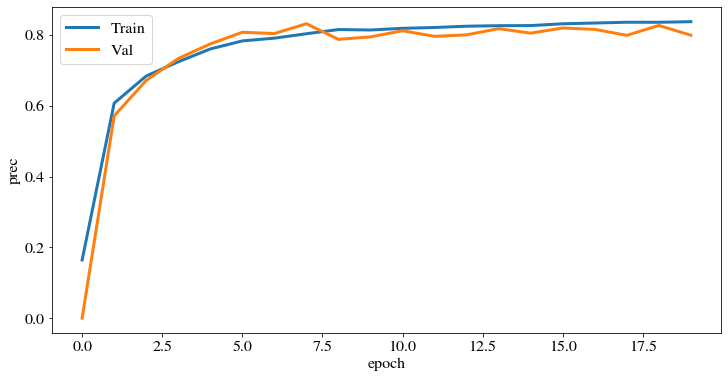

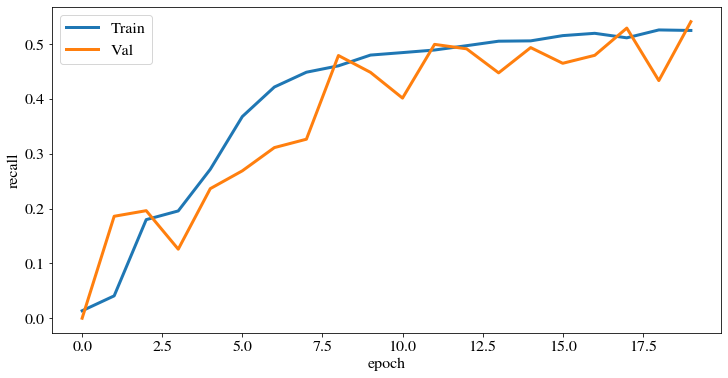

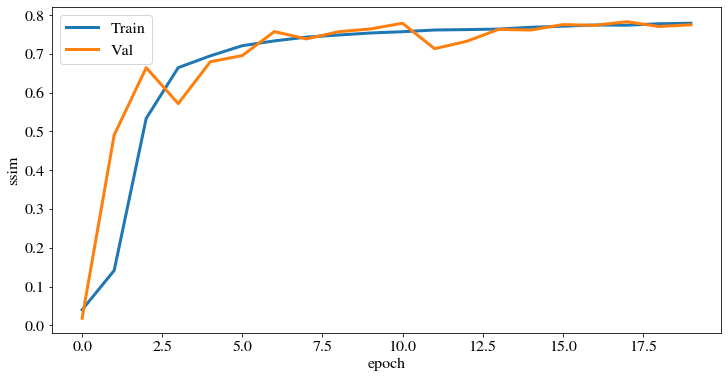

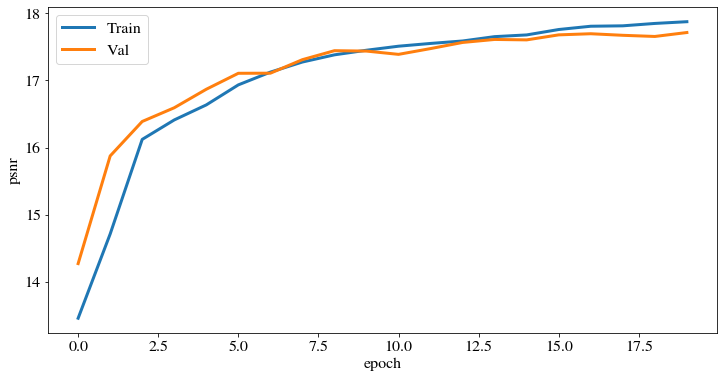

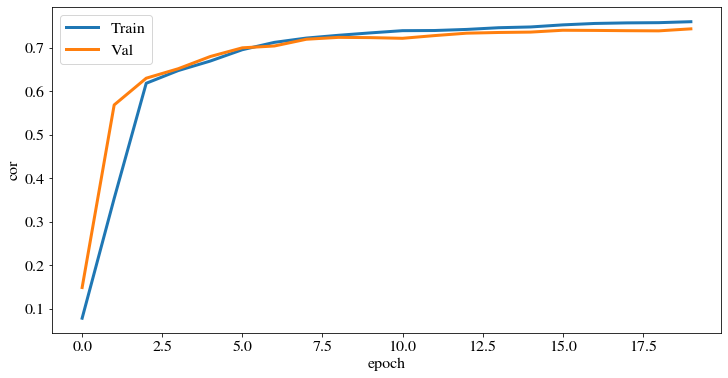

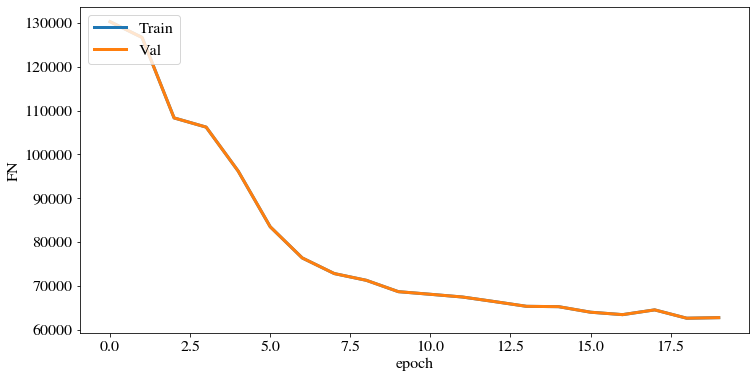

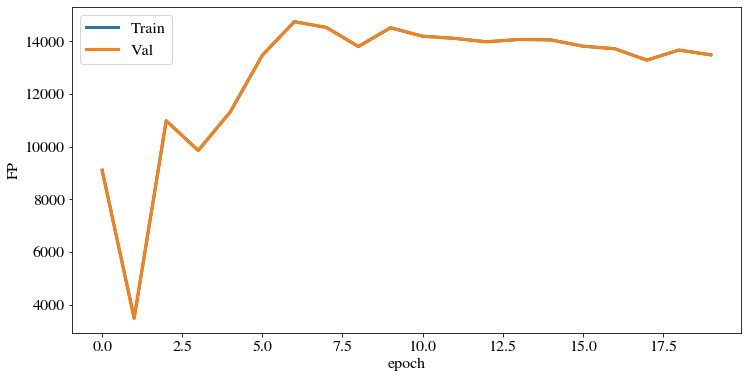

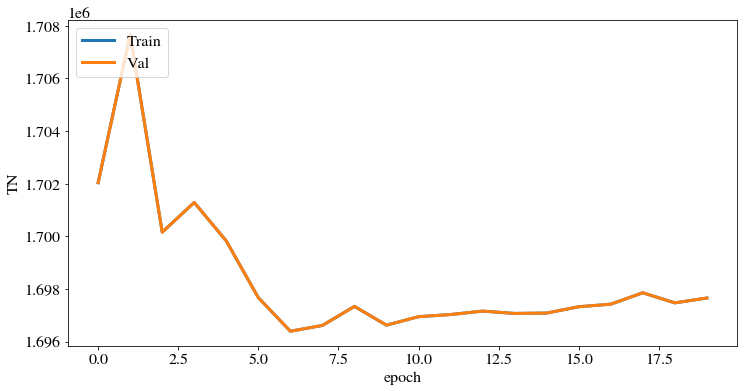

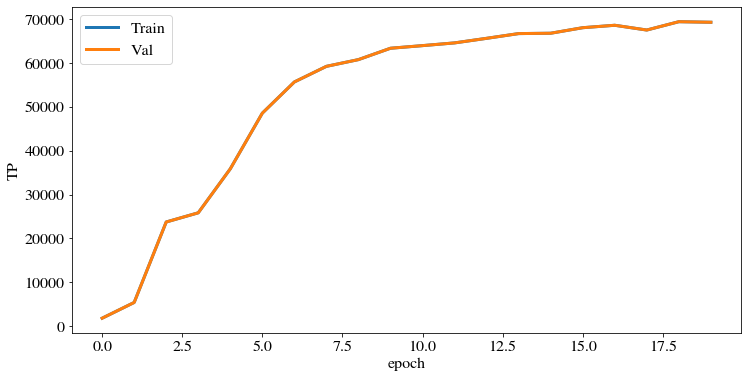

In [0]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss.png')
#files.download('loss.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Val')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('acc.png')
#files.download('acc.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['binary_crossentropy'], label='Train')
plt.plot(history.history['val_binary_crossentropy'], label='Val')
plt.ylabel('binary_crossentropy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('binary_crossentropy.png')
#files.download('binary_crossentropy.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['mse'], label='Train')
plt.plot(history.history['val_mse'], label='Val')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('mse.png')
#files.download('mse.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['prec'], label='Train')
plt.plot(history.history['val_prec'], label='Val')
plt.ylabel('prec')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('prec.png')
#files.download('prec.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['recall'], label='Train')
plt.plot(history.history['val_recall'], label='Val')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('recall.png')
#files.download('recall.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['ssim'], label='Train')
plt.plot(history.history['val_ssim'], label='Val')
plt.ylabel('ssim')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('ssim.png')
#files.download('ssim.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['psnr'], label='Train')
plt.plot(history.history['val_psnr'], label='Val')
plt.ylabel('psnr')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('psnr.png')
#files.download('psnr.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['cor'], label='Train')
plt.plot(history.history['val_cor'], label='Val')
plt.ylabel('cor')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('cor.png')
#files.download('cor.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['FN'], label='Train')
plt.plot(history.history['FN'], label='Val')
plt.ylabel('FN')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('FN.png')
#files.download('FN.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['FP'], label='Train')
plt.plot(history.history['FP'], label='Val')
plt.ylabel('FP')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('FP.png')
#files.download('FP.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['TN'], label='Train')
plt.plot(history.history['TN'], label='Val')
plt.ylabel('TN')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('TN.png')
#files.download('TN.png')
#
plt.figure(figsize=(12,6))
plt.plot(history.history['TP'], label='Train')
plt.plot(history.history['TP'], label='Val')
plt.ylabel('TP')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('TP.png')
#files.download('TP.png')

In [0]:
# Select a random observation, initial trajectory and predicted trajectory
itest = 1
track = X[itest, :, :, :, :]
for i in range(Noutput):
  new_pos = model.predict(track[None, :, :, :, :])
  track = np.concatenate((track, new_pos), axis=0)
print("track:", track.shape)

track: (15, 64, 64, 1)


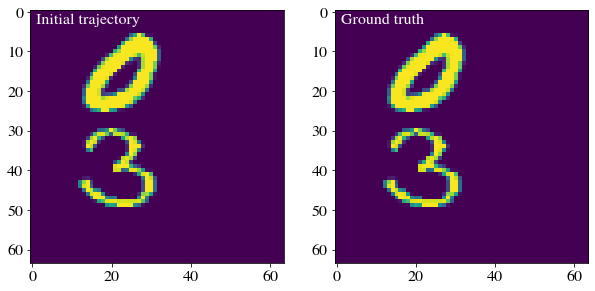

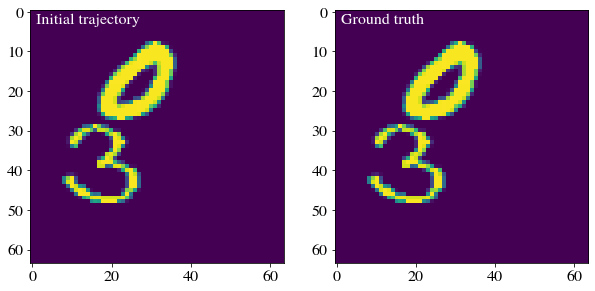

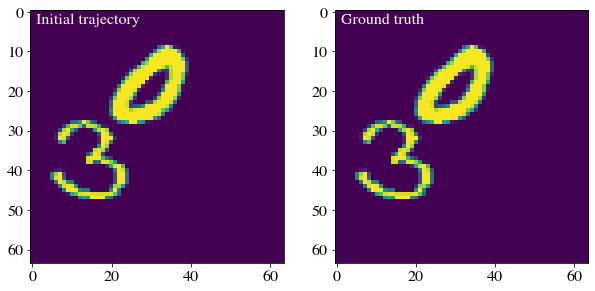

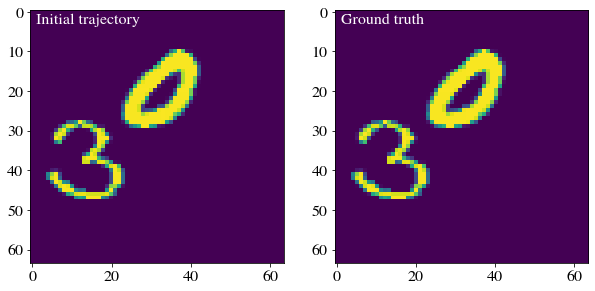

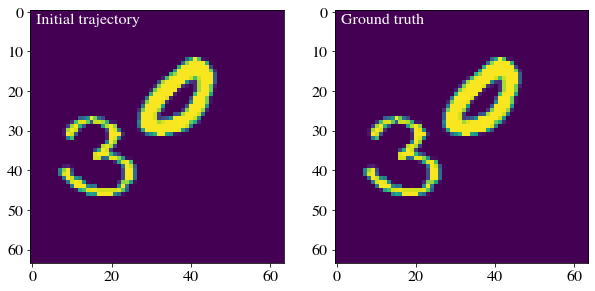

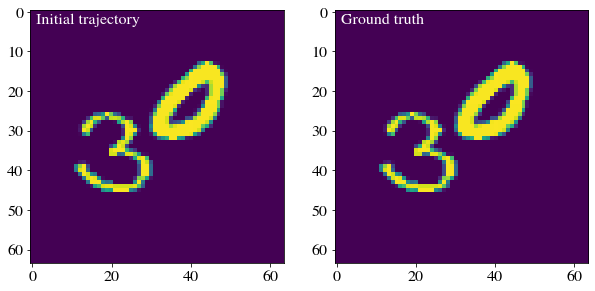

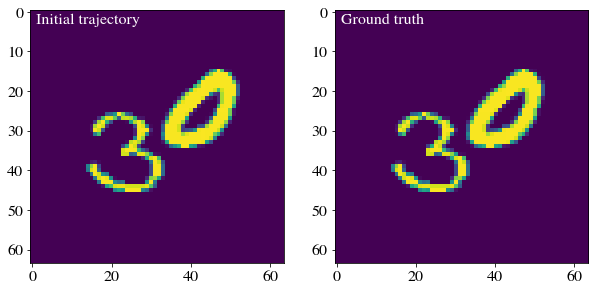

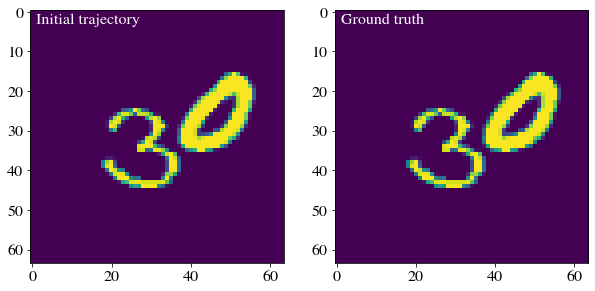

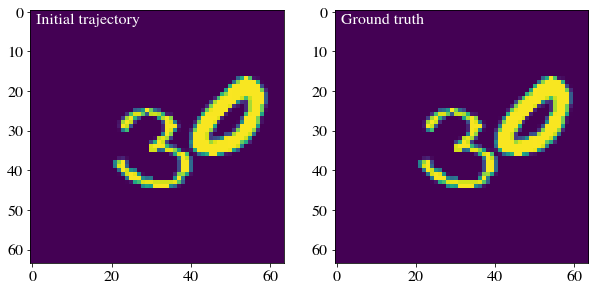

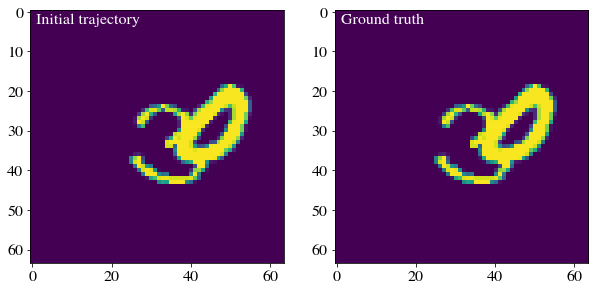

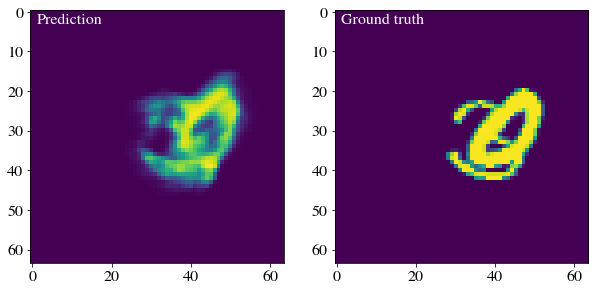

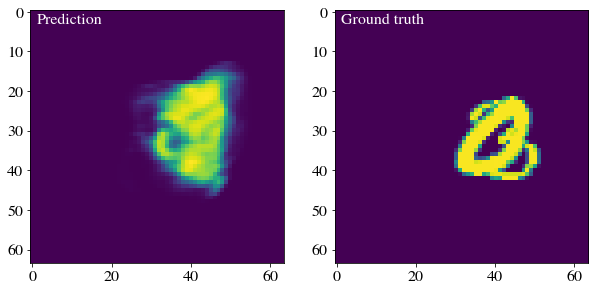

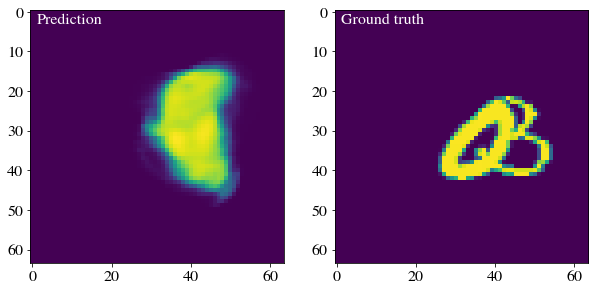

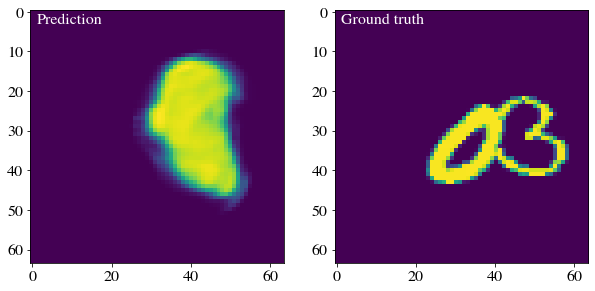

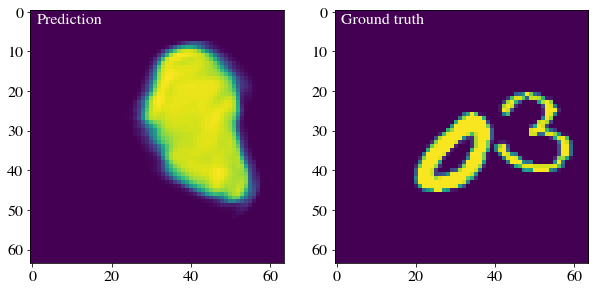

In [0]:
# Plot results
true_track = data[itest, :, :, :, :]

for i in range(Ninput+Noutput):
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    if i >= Ninput:
        plt.text(1, 3, 'Prediction', color='w')
    else:
        plt.text(1, 3, 'Initial trajectory', color='w')
    plt.imshow(track[i, :, :, 0])

    plt.subplot(122)
    plt.text(1, 3, 'Ground truth', color='w')
    plt.imshow(true_track[i, :, :, 0])

    plt.savefig('anim_%i.png' % (i+1))
    #files.download('anim_%i.png' % (i+1))